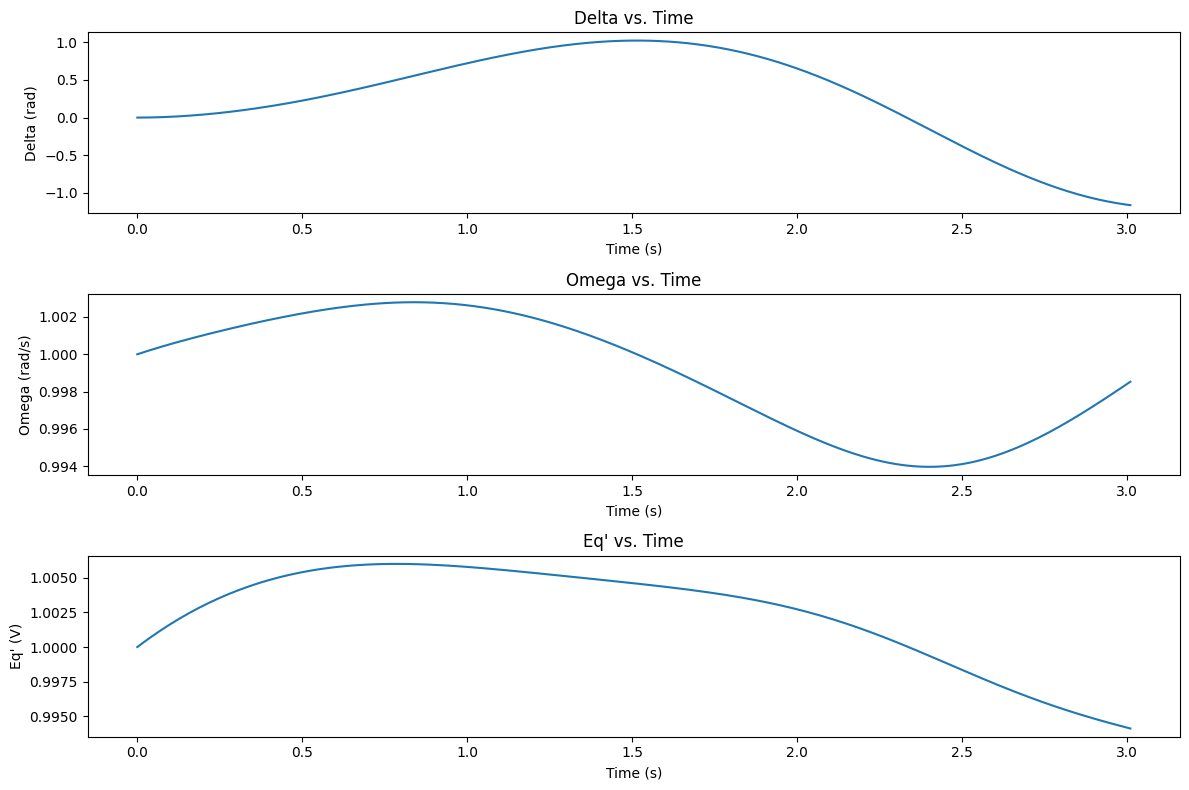

In [7]:
import powerflow as pf
import dynamic_models as dm
import os
import numpy as np
import matplotlib.pyplot as plt

current_directory = os.getcwd()
filename = 'IEEE 14 bus.raw'
filepath = os.path.join(current_directory, filename)

network = pf.power_network(filepath, recip_gamma=0.0001)

pm1 = p_m=network.data['generator'][0]['PG']/network.S_base
pm2 = p_m=network.data['generator'][1]['PG']/network.S_base
pm3 = p_m=network.data['generator'][2]['PG']/network.S_base
pm6 = p_m=network.data['generator'][3]['PG']/network.S_base
pm8 = p_m=network.data['generator'][4]['PG']/network.S_base

machine1 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=1, delta_0=0, M=10, p_m=pm1-0.55, p_m_ref=pm1, eqprime_0=0.8,
                                                       K_p_g=0.0, K_i_g=160, K_d_g=0,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine2 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=2, delta_0=0, M=5, p_m=pm2, p_m_ref=pm2, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine3 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=3, delta_0=0, M=5, p_m=pm3, p_m_ref=pm3, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine6 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=6, delta_0=0, M=5, p_m=pm6, p_m_ref=pm6, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine8 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=8, delta_0=0, M=5, p_m=pm8, p_m_ref=pm8, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.266)

machines =[machine1, machine2, machine3, machine6, machine8]

t0 = 0
tf = 3
dt=0.01
dm.PS_trapezoidal(network, machines, t0, tf, dt)

#region
import matplotlib.pyplot as plt
#for machine in machines:
toplot=machine6
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(toplot.t_hist, toplot.delta_hist)
plt.title('Delta vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Delta (rad)')

plt.subplot(3, 1, 2)
plt.plot(toplot.t_hist, toplot.omega_hist)
plt.title('Omega vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(toplot.t_hist, toplot.eqprime_hist)
plt.title('Eq\' vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Eq\' (V)')

plt.tight_layout()
plt.show()
#endregion

In [6]:
# Time params
t0 = 0
tf = 3

solution, t_hist, reference_confidence, decades, computation_time = dm.PS_transient_reference(
    network, machines, t0, tf, desired_confidence=1e-2)

# Create a DataFrame for show
import pandas as pd
df = pd.DataFrame({'Decade': decades, 'Computation Time, s': computation_time})

df

Running Forward Euler with a timestep of dt = 10^(-1) seconds.
Solution contains NaN or Inf values. Skipping this timestep.

Running Forward Euler with a timestep of dt = 10^(-2) seconds.
Running Forward Euler with a timestep of dt = 10^(-3) seconds.
Reference Confidence: 0.27912253950386123

Running Forward Euler with a timestep of dt = 10^(-4) seconds.
Reference Confidence: 0.03076861723825708

Running Forward Euler with a timestep of dt = 10^(-5) seconds.
Reference Confidence: 0.0069304726318222265

Surpassed desired confidence with: 0.0069304726318222265 at dt = 10^(-5) seconds.


,Decade,"Computation Time, s"
0,0.10000,0.012710
1,0.01000,0.101528
2,0.00100,1.036231
3,0.00010,10.056970
4,0.00001,104.011060


In [ ]:
#region
machines =[machine1, machine2, machine3, machine6, machine8]

def PS_forward_euler(network, machines=None, t0=0, tf=10, dt=1e-3, reset=False):
    '''
    Must take a network. Machines are optional. Will use the Richardson approximation for the network.
    '''
    # Helper function
    states_per_machine = 3
    def combined_differential_equations(x):
        # Split x back into individual machine states
        derivatives = []

        for i, machine in enumerate(machines):
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Compute the derivatives for this machine
            machine_derivatives = machine.differential_equations(states=machine_state)
            derivatives.append(machine_derivatives)

        # Include the Richardson states
        derivatives.append(network.powerflow_decoupled_Richardson())

        return np.concatenate(derivatives)

    m_states = len(machines)*states_per_machine
    n_states = network.state.shape[0]
    states = m_states + n_states

    E_inv = np.eye(states)  
    E_inv[m_states:, m_states:] *= network.recip_gamma  
    
    if reset:
        network.reset()
        if machines is not None:
            for machine in machines:
                machine.reset()

    if machines is not None:
        for machine in machines:
            machine.t = t0
            machine.dt = dt
            machine.t_hist.append(t0)

    network.t_hist.append(t0)

    t=t0
    while t<tf:
        # Step t forward
        t += dt

        if machines is not None:
            # Update each machine
            for machine in machines:

                # Extract generator outputs from current state
                generator_outputs = network.extract_generator_outputs(external=True)

                # When indexing is needed
                bus_idx_machine = machine.bus_ID-1

                # Update each machine based on the power flow results
                machine.P = generator_outputs[bus_idx_machine]['P']
                machine.Q = generator_outputs[bus_idx_machine]['Q']
                machine.V = network.V[bus_idx_machine]
                machine.theta = network.theta[bus_idx_machine]
                machine.bus_type = network.bus_types[bus_idx_machine] # Can change from Qlims

        x = [np.array([m.delta, m.omega, m.eqprime]) for m in machines]
        x.append(network.state.copy())
        x = np.concatenate(x)
        f = combined_differential_equations(x)
        x += dt * E_inv @ f

        for i, machine in enumerate(machines):
            # Extracting states for the current machine from the large state vector
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Update machine states
            machine.delta, machine.omega, machine.eqprime = machine_state

            # Update the history of the machine
            machine.t = t
            machine.t_hist.append(t)
            machine.delta_hist.append(machine.delta)
            machine.omega_hist.append(machine.omega)
            machine.eqprime_hist.append(machine.eqprime)
            machine.update_network_quantities()
            network.update_network_from_machine(machine.P, machine.Q, machine.V, machine.theta, 
                                                machine.bus_ID-1, machine.bus_type)

        # Update the network
        network.state = x[len(machines)*states_per_machine:].copy()
        network.update_PQVtheta()
        network.t=t
        network.t_hist.append(t)
        network.state_hist.append(network.state.copy())

t0 = 0
tf = 0.1
dt=0.0001
PS_forward_euler(network, machines, t0, tf, dt)

import matplotlib.pyplot as plt


#for machine in machines:
toplot=machine6
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(toplot.t_hist, toplot.delta_hist)
plt.title('Delta vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Delta (rad)')

plt.subplot(3, 1, 2)
plt.plot(toplot.t_hist, toplot.omega_hist)
plt.title('Omega vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(toplot.t_hist, toplot.eqprime_hist)
plt.title('Eq\' vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Eq\' (V)')

plt.tight_layout()
plt.show()
#endregion

In [ ]:
# Time params
t0 = 0
tf = 3
dt = 1e-2 # Show 1e-1 goes unstable

dm.PS_trapezoidal(machines, network, t0, tf, dt, reset=True,
               homotopy_continuation=False, dynamic=True)
#PS_forward_euler(network, machines, t0, tf, dt)

import matplotlib.pyplot as plt

#for machine in machines:
toplot=machine6
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(toplot.t_hist, toplot.delta_hist)
plt.title('Delta vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Delta (rad)')

plt.subplot(3, 1, 2)
plt.plot(toplot.t_hist, toplot.omega_hist)
plt.title('Omega vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(toplot.t_hist, toplot.eqprime_hist)
plt.title('Eq\' vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Eq\' (V)')

plt.tight_layout()
plt.show()

In [ ]:
#for machine in machines:
toplot=machine6
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(toplot.t_hist, toplot.delta_hist)
plt.title('Delta vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Delta (rad)')

plt.subplot(3, 1, 2)
plt.plot(toplot.t_hist, toplot.omega_hist)
plt.title('Omega vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(toplot.t_hist, toplot.eqprime_hist)
plt.title('Eq\' vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Eq\' (V)')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

solution = np.column_stack(network.state_hist).T
t = network.t_hist

# Extracting specific state variables for plotting
P_states = solution[:, :2]*network.S_base
Q_states_PV = solution[:, 2:2 + network.num_PV]*network.S_base
theta_states_PV = solution[:, 2 + network.num_PV:2 + 2*network.num_PV]*180/np.pi
theta_states_PQ = solution[:, 2 + 2*network.num_PV:2 + 2*network.num_PV + network.num_PQ]*180/np.pi
Q_states_PQ = solution[:, 2 + 2*network.num_PV + network.num_PQ:]*network.S_base
V_states = solution[:, -network.num_PQ:] #*V_base[np.where(bus_types == 1)[0]]

# Plotting P trajectory
plt.figure(figsize=(10, 5))
plt.plot(t, P_states)
plt.title('P Trajectory (Slack Bus)')
plt.xlabel('Time')
plt.ylabel('Power (PU)')
plt.ylim([-50,300])
plt.legend(['P_slack', 'Q_slack'])
plt.grid(True)

# Plotting Q trajectories for PV buses
plt.figure(figsize=(10, 5))
plt.plot(t, Q_states_PV)
plt.title('Q Trajectory (PV Buses)')
plt.xlabel('Time')
plt.ylabel('Reactive Power (PU)')
plt.ylim([-50,300])
plt.legend([f'Q_gen_bus_{i}' for i in np.where(network.bus_types == 2)[0] + 1])  # +1 for 1-indexed bus numbering
plt.grid(True)

# Plotting Theta states for PV and PQ buses
plt.figure(figsize=(10, 5))
plt.plot(t, theta_states_PV, label='PV Buses')
plt.plot(t, theta_states_PQ, label='PQ Buses', linestyle='--')
plt.title('Theta States (Voltage Angles)')
plt.xlabel('Time')
plt.ylabel('Angle (Radians)')
plt.legend([f'theta_bus_{i}' for i in np.where(network.bus_types == 2)[0] + 1] + [f'theta_bus_{i}' for i in np.where(network.bus_types == 1)[0] + 1])
plt.grid(True)

# Plotting V states for PQ buses
plt.figure(figsize=(10, 5))
plt.plot(t, V_states*network.data['bus'][0]['BASKV'])
plt.title('V States (Voltage Magnitudes at PQ Buses)')
plt.xlabel('Time, s')
plt.ylabel('Voltage, kV')
plt.legend([f'V_bus_{i}' for i in np.where(network.bus_types == 1)[0] + 1])  # +1 for 1-indexed bus numbering
plt.grid(True)

In [ ]:
import plotly.graph_objects as go
import powerflow as pf
import networkx as nx
import pandas as pd
import numpy as np
import os

current_directory = os.getcwd()
filename = 'IEEE 14 bus.raw'
filepath = os.path.join(current_directory, filename)

network = pf.power_network(filepath)
network.result_dataframes()
network.create_figure()

network.results['Presolved'] = {
    'bus_df': network.bus_df,
    'branch_df': network.branch_df,
    'graph': network.G,
    'figure': network.fig
}

In [ ]:
network.results

In [ ]:
import plotly.graph_objects as go
import powerflow as pf
import dynamic_models as dm
import networkx as nx
import pandas as pd
import numpy as np
import os

current_directory = os.getcwd()
filename = 'IEEE 14 bus.raw'
filepath = os.path.join(current_directory, filename)

network = pf.power_network(filepath)

pm1 = p_m=network.data['generator'][0]['PG']/network.S_base
pm2 = p_m=network.data['generator'][1]['PG']/network.S_base
pm3 = p_m=network.data['generator'][2]['PG']/network.S_base
pm6 = p_m=network.data['generator'][3]['PG']/network.S_base
pm8 = p_m=network.data['generator'][4]['PG']/network.S_base

machine1 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=1, delta_0=0, M=10, p_m=pm1, p_m_ref=pm1, eqprime_0=0.8,
                                                       K_p_g=0.05, K_i_g=160, K_d_g=0,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine2 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=2, delta_0=0, M=3, p_m=pm2, p_m_ref=pm2, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine3 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=3, delta_0=0, M=3, p_m=pm3, p_m_ref=pm3, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine6 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=6, delta_0=0, M=3, p_m=pm6, p_m_ref=pm6, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.093) # Need to tune
machine8 = dm.sync_machine_Order_III_with_PID_controllers(bus_ID=8, delta_0=0, M=3, p_m=pm8, p_m_ref=pm8, eqprime_0=1,
                                                   r_a=1e-3, x_d=1.8, x_d_prime=0.266)

machines =[machine1, machine2, machine3, machine6, machine8]

def PS_forward_euler(machines, network, t0, tf, dt, reset=False):

    if reset:
        network.reset()
        for machine in machines:
            machine.reset()

    t=t0
    for machine in machines:
        machine.t = t0
        machine.dt = dt
        machine.t_hist.append(t0)

    # Solve the power flow problem using Newton-Raphson method
    V, theta, P, Q, bus_types, log = network.newton_raphson_power_flow()

    # Extract generator outputs from solved power flow
    generator_outputs = network.extract_generator_outputs(external=True)

    while t<tf:

        # Step t forward
        t += dt

        # Step forward each machine to t
        for machine in machines:

            # When indexing is needed
            bus_idx_machine = machine.bus_ID-1

            # Update each machine based on the power flow results
            machine.P = generator_outputs[bus_idx_machine]['P']
            machine.Q = generator_outputs[bus_idx_machine]['Q']
            machine.V = V[bus_idx_machine]
            machine.theta = theta[bus_idx_machine]
            machine.bus_type = bus_types[bus_idx_machine] # Can change from Qlims

            # Find the slopes at t_{n-1}
            # print(ddelta_dt, domega_dt, deqprime_dt)

            ddelta_dt, domega_dt, deqprime_dt = machine.differential_equations()
            #print(ddelta_dt, domega_dt, deqprime_dt)

            # Step forward with ForwardEuler
            machine.delta += dt*ddelta_dt
            machine.omega += dt*domega_dt
            machine.eqprime += dt*deqprime_dt

            # Update network quantities in the machine based on new states
            # if machine.bus_type == 1: # debugging
            #     print('Network values: ', generator_outputs[bus_idx_machine]['P'], generator_outputs[bus_idx_machine]['Q'], V[bus_idx_machine], theta[bus_idx_machine])
            #     P_machine, Q_machine, V_machine, theta_machine = machine.update_network_quantities()
            #     print(f'Machine {machine.bus_ID}, bus_type {machine.bus_type}:', machine.delta, machine.omega, machine.eqprime, '\n')

            # Update network from machine network quantities
            # network.update_network_from_machine(P_machine, Q_machine, V_machine, theta_machine, bus_idx_machine)

            # Update the history of the machine
            machine.t = t
            machine.t_hist.append(t)
            machine.delta_hist.append(machine.delta)
            machine.omega_hist.append(machine.omega)
            machine.eqprime_hist.append(machine.eqprime)

# Time params
t0 = 0.0
tf = 30
dt = 1e-2
PS_forward_euler(machines, network, t0, tf, dt)

import matplotlib.pyplot as plt

#for machine in machines:
toplot=machine6
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(toplot.t_hist, toplot.delta_hist)
plt.title('Delta vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Delta (rad)')

plt.subplot(3, 1, 2)
plt.plot(toplot.t_hist, toplot.omega_hist)
plt.title('Omega vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(toplot.t_hist, toplot.eqprime_hist)
plt.title('Eq\' vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Eq\' (V)')

plt.tight_layout()
plt.show()

#network.remove_branch(10, 11)
#network.remove_branch(6, 12)
#network.newton_raphson_power_flow()
network.result_dataframes()
network.create_figure()
network.fig.show()

#network.N_1_contingency_screening()

In [ ]:
network.contingency_screening.keys()

In [ ]:
network.contingency_screening['Branch removal: Line 2-3']['figure'].show()

In [ ]:
dictionary = {
    'key': 120
}

dictionary['key']

OLD STUFF

In [ ]:
import inspect

def finite_difference_jacobian(f, x, u=None, t=None, epsilon=1e-5):
    '''
    returns jacobian

    Requires all input functions to wrap their parameters, e.g. via a lambda function.
    '''

    # Helper functions
    def call_f(x, u, t):
        if num_args_f == 1:
            return f(x)
        elif num_args_f == 2:
            return f(x, u)
        elif num_args_f == 3:
            return f(x, u, t)
        else:
            raise AttributeError("Unexpected number of arguments in f($\cdot$).")

    def call_u(x, t):
        if num_args_u == 1:
            return u(t)
        elif num_args_u == 2:
            return u(x, t)
        else:
            raise AttributeError("Unexpected number of arguments in u($\cdot$).")

    # Number of states
    n = len(x)

    # Determine the number of arguments f expects
    num_args_f = len(inspect.signature(f).parameters)

    # Number of controls
    if callable(u):
        num_args_u = len(inspect.signature(u).parameters)
        u_value = call_u(x, t)
    elif u is not None:
        if not np.isscalar(u):
            u_value = u.copy()
            m = len(u_value)
        else:
            u_value = [u]
            m = 1
    else:
        u_value = 0
        m = 0

    # Initialize Jacobian
    jacobian = np.zeros((n, n + m))

    # Compute partial derivatives wrt x
    for i in range(n):
        x_plus = np.copy(x)
        x_plus[i] += epsilon
        f_plus = call_f(x_plus, u_value, t)

        x_minus = np.copy(x)
        x_minus[i] -= epsilon
        f_minus = call_f(x_minus, u_value, t)

        jacobian[:, i] = (f_plus - f_minus) / (2 * epsilon)

    # Compute partial derivatives wrt u, if u is provided
    if u_value is not None:
        for i in range(m):
            u_plus = np.copy(u_value)
            u_plus[i] += epsilon
            f_plus = call_f(x, u_plus, t)

            u_minus = np.copy(u_value)
            u_minus[i] -= epsilon
            f_minus = call_f(x, u_minus, t)

            jacobian[:, n + i] = (f_plus - f_minus) / (2 * epsilon)

    return jacobian

def NewtonNd(f, Jf, x0, eps_f, eps_dx=np.inf, eps_xrel=np.inf, u=None, t=None, max_iter=50,
             homotopy_continuation=False):
    '''
    returns x_k, f_k, f_values, x_values, converged

    Requires all input functions to wrap their parameters, e.g. via a lambda function.
    '''
    # Helper functions
    num_args_f = len(inspect.signature(f).parameters)
    num_args_Jf = len(inspect.signature(Jf).parameters)
    def call_f(x, u=None, t=None):
        if num_args_f == 1:
            return f(x)
        elif num_args_f == 2:
            return f(x, u)
        elif num_args_f == 3:
            return f(x, u, t)
        else:
            raise AttributeError("Unexpected number of arguments in f($\cdot$).")

    def call_Jf(x, u, t):
        if num_args_Jf == 1:
            return Jf(x)
        elif num_args_Jf == 2:
            return Jf(x, u)
        elif num_args_Jf == 3:
            return Jf(x, u, t)
        else:
            raise AttributeError("Unexpected number of arguments in Jf($\cdot$).")

    def call_u(x, t):
        if num_args_u == 1:
            return u(t)
        elif num_args_u == 2:
            return u(x, t)
        else:
            raise AttributeError("Unexpected number of arguments in u($\cdot$).")

    # Initialize
    x_k = x0.copy()

    norm_hist = []
    if callable(u):
        num_args_u = len(inspect.signature(u).parameters)
        u_k = call_u(x_k, t)
    elif u is not None:
        u_k = u.copy() if not np.isscalar(u) else u
    else:
        u_k=None

    q=0
    qp = 0.01
    qm = 0.1
    f_k = call_f(x_k, u_k, t)
    Jf_k = call_Jf(x_k, u_k, t)

    # Lists for storing historical values
    f_values = [f_k.copy() if not np.isscalar(f_k) else f_k]
    x_values = [x_k.copy() if not np.isscalar(x_k) else x_k]
    converged = False

    # Iterate until solved or max_iter
    for k in range(max_iter):

        # Try to solve
        if not np.isscalar(f_k):
            try: # N > 1
                delta_x = np.linalg.solve(Jf_k, -f_k)
            except np.linalg.LinAlgError:
                return x_k, f_k, f_values, x_values, False
        elif Jf_k != 0: # N = 1
            delta_x = -f_k/Jf_k
        else:
            return ArithmeticError('Cannot solve due to division by zero.')

        # Prepare next iteration
        x_k = x_k.astype(float) + delta_x
        if callable(u): u_k = call_u(x_k, t)
        elif u is not None: u_k = u.copy() if not np.isscalar(u) else u

        f_k = call_f(x_k, u_k, t)
        Jf_k = call_Jf(x_k, u_k, t)

        # Append results to history
        f_values.append(f_k.copy() if not np.isscalar(f_k) else f_k)
        x_values.append(x_k.copy() if not np.isscalar(x_k) else x_k)

        if homotopy_continuation and len(norm_hist)>=2:
            if (norm_hist[-1][i] > norm_hist[-2][i] for i in range(3)):
                if q-qm>=0: q-= qm
                else: q=0
                f_k = q*call_f(x_k, u_k, t) + (1-q)*x0.copy()
                J_k = q*call_Jf(x_k, u_k, t) + (1-q)*np.eye(f_k.shape[0])
            elif (norm_hist[-1][i] >= norm_hist[-2][i] for i in range(3)):
                if q+qp<=1: q+=0.01 
                else: q=1
                f_k = q*call_f(x_k, u_k, t) + (1-q)*x0.copy()
                J_k = q*call_Jf(x_k, u_k, t) + (1-q)*np.eye(J_k.shape)        

        # Check convergence
        norm_f = np.linalg.norm(f_k, np.inf)
        norm_dx = np.linalg.norm(delta_x, np.inf)
        norm_dx_xk = np.linalg.norm(delta_x, np.inf) / max(np.linalg.norm(x_k, np.inf), 1e-12)
        norm_hist.append(np.array([norm_f, norm_dx, norm_dx_xk]))

        if not np.isscalar(f_k): # N > 1
            if (norm_f < eps_f and norm_dx < eps_dx and norm_dx_xk < eps_xrel):
                converged = True
                break
        else: # N = 1
            if (np.abs(f_k) < eps_f and
                np.abs(delta_x) < eps_dx and
                np.abs(delta_x) / max(np.abs(x_k), 1e-12) < eps_xrel):
                converged = True
                break

    return x_k, f_k, f_values, x_values, converged

def PS_trapezoidal(machines, network, t0, tf, dt, 
                   dynamic=False, homotopy_continuation=False,
                   reset=False):
    
    states_per_machine = 3
    m_states = len(machines)*states_per_machine
    n_states = network.state.shape[0]
    states = m_states + n_states
    E = np.eye(states)  
    E[m_states:, m_states:] *= 0.01  

    # Helper function
    def combined_differential_equations(x):
        # Split x back into individual machine states
        derivatives = []

        for i, machine in enumerate(machines):
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Compute the derivatives for this machine
            machine_derivatives = machine.differential_equations(states=machine_state)
            derivatives.append(machine_derivatives)

        # Include the Richardson states
        derivatives.append(network.powerflow_decoupled_Richardson(states=x[len(machines)*states_per_machine:]))

        return np.concatenate(derivatives)

    if reset:
        network.reset()
        for machine in machines:
            machine.reset()

    t=t0
    dt0=dt
    for machine in machines:
        machine.t = t0
        machine.dt = dt
        machine.t_hist.append(t0)

    while t < tf:

        generator_outputs = network.extract_generator_outputs(external=True)

        # Update machine parameters based on power flow results
        for i, machine in enumerate(machines):
            bus_idx_machine = machine.bus_ID - 1
            machine.P = generator_outputs[bus_idx_machine]['P']
            machine.Q = generator_outputs[bus_idx_machine]['Q']
            machine.V = network.V[bus_idx_machine]
            machine.theta = network.theta[bus_idx_machine]
            machine.bus_type = network.bus_types[bus_idx_machine]

        # Concatenating the initial states of all machines
        x_nm1 = [np.array([m.delta, m.omega, m.eqprime]) for m in machines]
        x_nm1.append(network.state.copy())
        x_nm1 = np.concatenate(x_nm1)

        # Dynamic timestep adjustment
        if dynamic:
            # Estimate the rate of change of states
            derivatives = []
            for machine in machines:
                derivatives.append(machine.ddelta_dt)
                derivatives.append(machine.domega_dt)
                derivatives.append(machine.deqprime_dt)
            derivatives += network.dstate_dt.copy().tolist() # concatenates
            max_change_rate = max(derivatives)
            if max_change_rate > np.max(x_nm1)/10:
                dt = max(dt0, dt / 2)  # Halve dt if change is rapid
            elif max_change_rate < np.max(x_nm1)/10:
                dt = min(dt0, dt * 1.5)  # Increase dt by 50% if change is slow

        # Step t forward
        t += dt

        # Compute gamma for the entire system
        gamma = E @ x_nm1 + (dt/2) * combined_differential_equations(x_nm1)

        # Define F and J for the entire system
        f = lambda x: combined_differential_equations(x)
        Jf = lambda x: finite_difference_jacobian(f, x=x)

        F_Trap = lambda x: E @ x - (dt/2) * f(x) - gamma
        J_Trap = lambda x: E - (dt/2) * Jf(x)

        # Run the Newton solver for the entire system at timestep t
        x, _, _, _, converged = NewtonNd(
            F_Trap, J_Trap, x0=x_nm1,
            eps_f=1e-5, eps_dx=1e-5, eps_xrel=1e-5,
            max_iter=100, homotopy_continuation=homotopy_continuation
        )

        # Check convergence
        if not converged:
            print(f'Newton solver failed to converge at t={t}.')
            break

        for i, machine in enumerate(machines):
            # Extracting states for the current machine from the large state vector
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Update machine states
            machine.delta, machine.omega, machine.eqprime = machine_state.copy()

            # Update the history of the machine
            machine.t = t
            machine.t_hist.append(t)
            machine.delta_hist.append(machine.delta)
            machine.omega_hist.append(machine.omega)
            machine.eqprime_hist.append(machine.eqprime)

        network.state = x[len(machines)*states_per_machine:].copy()
        network.update_PQVtheta()
        network.t=t
        network.t_hist.append(t)
        network.state_hist.append(network.state.copy())

def PS_forward_euler(network, machines=None, t0=0, tf=10, dt=1e-3, reset=False):
    '''
    Must take a network. Machines are optional. Will use the Richardson approximation for the network.
    '''
    # Helper function
    states_per_machine = 3
    def combined_differential_equations(x):
        # Split x back into individual machine states
        derivatives = []

        for i, machine in enumerate(machines):
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Compute the derivatives for this machine
            machine_derivatives = machine.differential_equations(states=machine_state)
            derivatives.append(machine_derivatives)

        # Include the Richardson states
        derivatives.append(network.powerflow_decoupled_Richardson())

        return np.concatenate(derivatives)

    m_states = len(machines)*states_per_machine
    n_states = network.state.shape[0]
    states = m_states + n_states

    E_inv = np.eye(states)  # Start with an nxn identity matrix
    E_inv[m_states:, m_states:] *= network.recip_gamma  # Multiply elements below the 15th row by 1e-6

    if reset:
        network.reset()
        if machines is not None:
            for machine in machines:
                machine.reset()

    if machines is not None:
        for machine in machines:
            machine.t = t0
            machine.dt = dt
            machine.t_hist.append(t0)

    network.t_hist.append(t0)

    t=t0
    while t<tf:
        # Step t forward
        t += dt

        if machines is not None:
            # Update each machine
            for machine in machines:

                # Extract generator outputs from current state
                generator_outputs = network.extract_generator_outputs(external=True)

                # When indexing is needed
                bus_idx_machine = machine.bus_ID-1

                # Update each machine based on the power flow results
                machine.P = generator_outputs[bus_idx_machine]['P']
                machine.Q = generator_outputs[bus_idx_machine]['Q']
                machine.V = network.V[bus_idx_machine]
                machine.theta = network.theta[bus_idx_machine]
                machine.bus_type = network.bus_types[bus_idx_machine] # Can change from Qlims

            ddelta_dt, domega_dt, deqprime_dt = machine.differential_equations()

        x = [np.array([m.delta, m.omega, m.eqprime]) for m in machines]
        x.append(network.state.copy())
        x = np.concatenate(x)
        f = combined_differential_equations(x)
        x += dt * E_inv @ f

        for i, machine in enumerate(machines):
            # Extracting states for the current machine from the large state vector
            state_start = i * states_per_machine
            state_end = state_start + states_per_machine
            machine_state = x[state_start:state_end]

            # Update machine states
            machine.delta, machine.omega, machine.eqprime = machine_state

            # Update the history of the machine
            machine.t = t
            machine.t_hist.append(t)
            machine.delta_hist.append(machine.delta)
            machine.omega_hist.append(machine.omega)
            machine.eqprime_hist.append(machine.eqprime)

        # Update the network
        network.state = x[len(machines)*states_per_machine:].copy()
        network.update_PQVtheta()
        network.t=t
        network.t_hist.append(t)
        network.state_hist.append(network.state.copy())
